In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import densenet121, DenseNet121_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 8,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 22,
    "image_size": 224,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 160MB/s]


In [8]:
# ---------------- LOSS FUNCTIONS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class AsymmetricLoss(nn.Module):
    """Asymmetric Loss for imbalanced medical data"""
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, reduction='mean'):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps
        self.reduction = reduction

    def forward(self, x, y):
        xs_pos = x
        xs_neg = x
        
        # Asymmetric clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=0)
        
        # Basic CE calculation
        los_pos = y * torch.log(torch.sigmoid(xs_pos).clamp(min=self.eps))
        los_neg = (1 - y) * torch.log((1 - torch.sigmoid(xs_neg)).clamp(min=self.eps))
        
        # Asymmetric focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = torch.sigmoid(xs_pos) * y
            pt1 = xs_neg * (1 - y)  # pt1 = (1 - p) * (1 - y)
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            loss = one_sided_w * (los_pos + los_neg)
        else:
            loss = los_pos + los_neg

        if self.reduction == 'mean':
            return -loss.mean()
        elif self.reduction == 'sum':
            return -loss.sum()
        else:
            return -loss

class ZLPRLoss(nn.Module):
    """Zero-threshold Log-sum-exp Pairwise Ranking Loss for multilabel classification"""
    def __init__(self, reduction='mean', eps=1e-8):
        super(ZLPRLoss, self).__init__()
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits, targets):
        """
        Args:
            logits: Model predictions (logits) of shape (batch_size, num_classes)
            targets: Ground truth labels of shape (batch_size, num_classes)
        """
        # ZLPR Loss: L_zlpr = log(1 + <y, e^(-s)>) + log(1 + <(1-y), e^s>)
        # where y is multi-hot label, s is logit vector
        
        # Positive term: log(1 + <y, e^(-s)>)
        exp_neg_logits = torch.exp(-logits)
        pos_term = torch.log(1 + torch.sum(targets * exp_neg_logits, dim=1) + self.eps)
        
        # Negative term: log(1 + <(1-y), e^s>)
        exp_logits = torch.exp(logits)
        neg_term = torch.log(1 + torch.sum((1 - targets) * exp_logits, dim=1) + self.eps)
        
        # Combine terms
        loss = pos_term + neg_term
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class CombinedLoss(nn.Module):
    """Combined Asymmetric + Focal Loss for NIH chest X-ray classification"""
    def __init__(self, focal_weight=0.3, asymmetric_weight=0.7, 
                 focal_gamma=2, asymmetric_gamma_neg=4, asymmetric_gamma_pos=1, 
                 asymmetric_clip=0.05):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.asymmetric_weight = asymmetric_weight
        self.focal_loss = FocalLoss(gamma=focal_gamma)
        self.asymmetric_loss = AsymmetricLoss(
            gamma_neg=asymmetric_gamma_neg, 
            gamma_pos=asymmetric_gamma_pos,
            clip=asymmetric_clip
        )

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        asymmetric = self.asymmetric_loss(inputs, targets)
        return self.focal_weight * focal + self.asymmetric_weight * asymmetric

class ZLPRCombinedLoss(nn.Module):
    """Combined ZLPR + Asymmetric Loss for advanced multilabel medical classification"""
    def __init__(self, zlpr_weight=0.6, asymmetric_weight=0.4,
                 asymmetric_gamma_neg=4, asymmetric_gamma_pos=1, asymmetric_clip=0.05):
        super(ZLPRCombinedLoss, self).__init__()
        self.zlpr_weight = zlpr_weight
        self.asymmetric_weight = asymmetric_weight
        self.zlpr_loss = ZLPRLoss()
        self.asymmetric_loss = AsymmetricLoss(
            gamma_neg=asymmetric_gamma_neg,
            gamma_pos=asymmetric_gamma_pos,
            clip=asymmetric_clip
        )

    def forward(self, inputs, targets):
        zlpr = self.zlpr_loss(inputs, targets)
        asymmetric = self.asymmetric_loss(inputs, targets)
        return self.zlpr_weight * zlpr + self.asymmetric_weight * asymmetric

In [9]:
# Using ZLPR Loss only for pure multilabel classification
criterion = ZLPRLoss(reduction='mean', eps=1e-8)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

print("Using ZLPR Loss Only")
print("- Zero-threshold Log-sum-exp Pairwise Ranking Loss")
print("- Handles label dependencies & pairwise ranking")
print("- Pure multilabel classification approach")
print("- Mathematical elegance without hyperparameter tuning")

Using ZLPR Loss Only
- Zero-threshold Log-sum-exp Pairwise Ranking Loss
- Handles label dependencies & pairwise ranking
- Pure multilabel classification approach
- Mathematical elegance without hyperparameter tuning


In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7988 | F1: 0.4056
[Validate] Cardiomegaly AUC: 0.8674 | F1: 0.3282
[Validate] Consolidation AUC: 0.7859 | F1: 0.2276
[Validate] Edema AUC: 0.8771 | F1: 0.2099
[Validate] Effusion AUC: 0.8505 | F1: 0.5028
[Validate] Emphysema AUC: 0.8672 | F1: 0.3111
[Validate] Fibrosis AUC: 0.7733 | F1: 0.1347
[Validate] Hernia AUC: 0.8976 | F1: 0.0102
[Validate] Infiltration AUC: 0.7097 | F1: 0.4281
[Validate] Mass AUC: 0.7522 | F1: 0.3052
[Validate] Nodule AUC: 0.6809 | F1: 0.2649
[Validate] Pleural_Thickening AUC: 0.7099 | F1: 0.1248
[Validate] Pneumonia AUC: 0.7632 | F1: 0.1115
[Validate] Pneumothorax AUC: 0.8580 | F1: 0.3394
[Validate] Avg AUC: 0.7994, Avg F1: 0.2646
Training Loss: 1.7640
Validation Loss: 1.6285
Validation AUC: 0.7994
Validation F1: 0.2646
✓ NEW BEST MODEL! Saved at models/best_model_20250916-192854.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8121 | F1: 0.4159
[Validate] Cardiomegaly AUC: 0.8740 | F1: 0.3675
[Validate] Consolidation AUC: 0.8023 | F1: 0.2523
[Validate] Edema AUC: 0.8780 | F1: 0.2273
[Validate] Effusion AUC: 0.8617 | F1: 0.5240
[Validate] Emphysema AUC: 0.8957 | F1: 0.4242
[Validate] Fibrosis AUC: 0.7992 | F1: 0.1345
[Validate] Hernia AUC: 0.9900 | F1: 0.1000
[Validate] Infiltration AUC: 0.7166 | F1: 0.4292
[Validate] Mass AUC: 0.7794 | F1: 0.3139
[Validate] Nodule AUC: 0.7333 | F1: 0.2568
[Validate] Pleural_Thickening AUC: 0.7494 | F1: 0.1710
[Validate] Pneumonia AUC: 0.7572 | F1: 0.1105
[Validate] Pneumothorax AUC: 0.8670 | F1: 0.3629
[Validate] Avg AUC: 0.8226, Avg F1: 0.2921
Training Loss: 1.6979
Validation Loss: 1.6213
Validation AUC: 0.8226
Validation F1: 0.2921
✓ NEW BEST MODEL! Saved at models/best_model_20250916-195433.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8243 | F1: 0.4335
[Validate] Cardiomegaly AUC: 0.8811 | F1: 0.3463
[Validate] Consolidation AUC: 0.7959 | F1: 0.2635
[Validate] Edema AUC: 0.8765 | F1: 0.2589
[Validate] Effusion AUC: 0.8657 | F1: 0.5399
[Validate] Emphysema AUC: 0.8958 | F1: 0.4279
[Validate] Fibrosis AUC: 0.8026 | F1: 0.1714
[Validate] Hernia AUC: 0.9852 | F1: 0.1081
[Validate] Infiltration AUC: 0.7229 | F1: 0.4426
[Validate] Mass AUC: 0.8056 | F1: 0.3147
[Validate] Nodule AUC: 0.7428 | F1: 0.2839
[Validate] Pleural_Thickening AUC: 0.7744 | F1: 0.1652
[Validate] Pneumonia AUC: 0.7966 | F1: 0.0996
[Validate] Pneumothorax AUC: 0.8767 | F1: 0.3759
[Validate] Avg AUC: 0.8319, Avg F1: 0.3023
Training Loss: 1.6775
Validation Loss: 1.5909
Validation AUC: 0.8319
Validation F1: 0.3023
✓ NEW BEST MODEL! Saved at models/best_model_20250916-202021.pth

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8317 | F1: 0.4554
[Validate] Cardiomegaly AUC: 0.8883 | F1: 0.3626
[Validate] Consolidation AUC: 0.8013 | F1: 0.2513
[Validate] Edema AUC: 0.8874 | F1: 0.2591
[Validate] Effusion AUC: 0.8650 | F1: 0.5370
[Validate] Emphysema AUC: 0.8835 | F1: 0.4351
[Validate] Fibrosis AUC: 0.8210 | F1: 0.1584
[Validate] Hernia AUC: 0.9858 | F1: 0.1379
[Validate] Infiltration AUC: 0.7152 | F1: 0.4417
[Validate] Mass AUC: 0.7930 | F1: 0.3657
[Validate] Nodule AUC: 0.7501 | F1: 0.3037
[Validate] Pleural_Thickening AUC: 0.7786 | F1: 0.1831
[Validate] Pneumonia AUC: 0.7818 | F1: 0.1176
[Validate] Pneumothorax AUC: 0.8736 | F1: 0.3841
[Validate] Avg AUC: 0.8326, Avg F1: 0.3138
Training Loss: 1.6597
Validation Loss: 1.5920
Validation AUC: 0.8326
Validation F1: 0.3138
✓ NEW BEST MODEL! Saved at models/best_model_20250916-204556.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8319 | F1: 0.4566
[Validate] Cardiomegaly AUC: 0.8909 | F1: 0.3852
[Validate] Consolidation AUC: 0.8091 | F1: 0.2655
[Validate] Edema AUC: 0.8847 | F1: 0.2922
[Validate] Effusion AUC: 0.8655 | F1: 0.5223
[Validate] Emphysema AUC: 0.8988 | F1: 0.4360
[Validate] Fibrosis AUC: 0.8167 | F1: 0.2206
[Validate] Hernia AUC: 0.9966 | F1: 0.4000
[Validate] Infiltration AUC: 0.7253 | F1: 0.4484
[Validate] Mass AUC: 0.8010 | F1: 0.3725
[Validate] Nodule AUC: 0.7445 | F1: 0.2988
[Validate] Pleural_Thickening AUC: 0.7915 | F1: 0.2249
[Validate] Pneumonia AUC: 0.7977 | F1: 0.1000
[Validate] Pneumothorax AUC: 0.8740 | F1: 0.3716
[Validate] Avg AUC: 0.8377, Avg F1: 0.3425
Training Loss: 1.6484
Validation Loss: 1.5831
Validation AUC: 0.8377
Validation F1: 0.3425
✓ NEW BEST MODEL! Saved at models/best_model_20250916-211200.pth

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bfcad774040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^Exception ignored in: ^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bfcad774040>  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():  
        ^ ^ ^^ ^^^^^^^^^^^^^^^^^^^^^

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8271 | F1: 0.4520
[Validate] Cardiomegaly AUC: 0.8901 | F1: 0.3942
[Validate] Consolidation AUC: 0.8045 | F1: 0.2495
[Validate] Edema AUC: 0.8902 | F1: 0.2805
[Validate] Effusion AUC: 0.8694 | F1: 0.5256
[Validate] Emphysema AUC: 0.9109 | F1: 0.4402
[Validate] Fibrosis AUC: 0.8085 | F1: 0.1547
[Validate] Hernia AUC: 0.9958 | F1: 0.1176
[Validate] Infiltration AUC: 0.7210 | F1: 0.4448
[Validate] Mass AUC: 0.7835 | F1: 0.3568
[Validate] Nodule AUC: 0.7430 | F1: 0.3136
[Validate] Pleural_Thickening AUC: 0.7936 | F1: 0.2214
[Validate] Pneumonia AUC: 0.7845 | F1: 0.1123
[Validate] Pneumothorax AUC: 0.8766 | F1: 0.3857
[Validate] Avg AUC: 0.8356, Avg F1: 0.3178
Training Loss: 1.6369
Validation Loss: 1.5923
Validation AUC: 0.8356
Validation F1: 0.3178
No improvement. Patience: 1/5

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8317 | F1: 0.4425
[Validate] Cardiomegaly AUC: 0.8946 | F1: 0.4121
[Validate] Consolidation AUC: 0.8129 | F1: 0.2772
[Validate] Edema AUC: 0.8878 | F1: 0.2673
[Validate] Effusion AUC: 0.8711 | F1: 0.5355
[Validate] Emphysema AUC: 0.8920 | F1: 0.4157
[Validate] Fibrosis AUC: 0.8229 | F1: 0.1940
[Validate] Hernia AUC: 0.9965 | F1: 0.1333
[Validate] Infiltration AUC: 0.7216 | F1: 0.4417
[Validate] Mass AUC: 0.8026 | F1: 0.3521
[Validate] Nodule AUC: 0.7583 | F1: 0.2902
[Validate] Pleural_Thickening AUC: 0.7835 | F1: 0.2022
[Validate] Pneumonia AUC: 0.7779 | F1: 0.1245
[Validate] Pneumothorax AUC: 0.8814 | F1: 0.3971
[Validate] Avg AUC: 0.8382, Avg F1: 0.3204
Training Loss: 1.6282
Validation Loss: 1.5768
Validation AUC: 0.8382
Validation F1: 0.3204
✓ NEW BEST MODEL! Saved at models/best_model_20250916-220259.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8261 | F1: 0.4384
[Validate] Cardiomegaly AUC: 0.8845 | F1: 0.4023
[Validate] Consolidation AUC: 0.8136 | F1: 0.2788
[Validate] Edema AUC: 0.8910 | F1: 0.2811
[Validate] Effusion AUC: 0.8717 | F1: 0.5391
[Validate] Emphysema AUC: 0.9121 | F1: 0.4156
[Validate] Fibrosis AUC: 0.8198 | F1: 0.2258
[Validate] Hernia AUC: 0.9969 | F1: 0.2857
[Validate] Infiltration AUC: 0.7225 | F1: 0.4410
[Validate] Mass AUC: 0.7943 | F1: 0.3605
[Validate] Nodule AUC: 0.7212 | F1: 0.3026
[Validate] Pleural_Thickening AUC: 0.7883 | F1: 0.1898
[Validate] Pneumonia AUC: 0.7810 | F1: 0.1138
[Validate] Pneumothorax AUC: 0.8815 | F1: 0.3760
[Validate] Avg AUC: 0.8361, Avg F1: 0.3322
Training Loss: 1.6202
Validation Loss: 1.5777
Validation AUC: 0.8361
Validation F1: 0.3322
No improvement. Patience: 1/5

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8362 | F1: 0.4546
[Validate] Cardiomegaly AUC: 0.8852 | F1: 0.3843
[Validate] Consolidation AUC: 0.8017 | F1: 0.2513
[Validate] Edema AUC: 0.8934 | F1: 0.2797
[Validate] Effusion AUC: 0.8712 | F1: 0.5450
[Validate] Emphysema AUC: 0.9052 | F1: 0.4329
[Validate] Fibrosis AUC: 0.8135 | F1: 0.1978
[Validate] Hernia AUC: 0.9979 | F1: 0.2667
[Validate] Infiltration AUC: 0.7284 | F1: 0.4544
[Validate] Mass AUC: 0.8073 | F1: 0.3686
[Validate] Nodule AUC: 0.7560 | F1: 0.2959
[Validate] Pleural_Thickening AUC: 0.7982 | F1: 0.2009
[Validate] Pneumonia AUC: 0.8050 | F1: 0.1078
[Validate] Pneumothorax AUC: 0.8850 | F1: 0.3978
[Validate] Avg AUC: 0.8417, Avg F1: 0.3313
Training Loss: 1.6123
Validation Loss: 1.5603
Validation AUC: 0.8417
Validation F1: 0.3313
✓ NEW BEST MODEL! Saved at models/best_model_20250916-225401.pth

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8377 | F1: 0.4575
[Validate] Cardiomegaly AUC: 0.8973 | F1: 0.4109
[Validate] Consolidation AUC: 0.8052 | F1: 0.2580
[Validate] Edema AUC: 0.8983 | F1: 0.2663
[Validate] Effusion AUC: 0.8757 | F1: 0.5349
[Validate] Emphysema AUC: 0.9012 | F1: 0.4128
[Validate] Fibrosis AUC: 0.8184 | F1: 0.2235
[Validate] Hernia AUC: 0.9974 | F1: 0.3636
[Validate] Infiltration AUC: 0.7288 | F1: 0.4510
[Validate] Mass AUC: 0.8101 | F1: 0.3522
[Validate] Nodule AUC: 0.7582 | F1: 0.2966
[Validate] Pleural_Thickening AUC: 0.8049 | F1: 0.2207
[Validate] Pneumonia AUC: 0.7993 | F1: 0.1229
[Validate] Pneumothorax AUC: 0.8910 | F1: 0.4014
[Validate] Avg AUC: 0.8445, Avg F1: 0.3409
Training Loss: 1.6062
Validation Loss: 1.5683
Validation AUC: 0.8445
Validation F1: 0.3409
✓ NEW BEST MODEL! Saved at models/best_model_20250916-231948.pth

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8304 | F1: 0.4515
[Validate] Cardiomegaly AUC: 0.8952 | F1: 0.4098
[Validate] Consolidation AUC: 0.8116 | F1: 0.2595
[Validate] Edema AUC: 0.8823 | F1: 0.2457
[Validate] Effusion AUC: 0.8728 | F1: 0.5515
[Validate] Emphysema AUC: 0.9040 | F1: 0.4155
[Validate] Fibrosis AUC: 0.8150 | F1: 0.2098
[Validate] Hernia AUC: 0.9975 | F1: 0.4444
[Validate] Infiltration AUC: 0.7224 | F1: 0.4444
[Validate] Mass AUC: 0.8145 | F1: 0.3858
[Validate] Nodule AUC: 0.7624 | F1: 0.2990
[Validate] Pleural_Thickening AUC: 0.7864 | F1: 0.2382
[Validate] Pneumonia AUC: 0.7963 | F1: 0.1163
[Validate] Pneumothorax AUC: 0.8812 | F1: 0.4053
[Validate] Avg AUC: 0.8409, Avg F1: 0.3483
Training Loss: 1.6010
Validation Loss: 1.5676
Validation AUC: 0.8409
Validation F1: 0.3483
No improvement. Patience: 1/5

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8385 | F1: 0.4615
[Validate] Cardiomegaly AUC: 0.8931 | F1: 0.3980
[Validate] Consolidation AUC: 0.8150 | F1: 0.2692
[Validate] Edema AUC: 0.8968 | F1: 0.3077
[Validate] Effusion AUC: 0.8777 | F1: 0.5464
[Validate] Emphysema AUC: 0.9265 | F1: 0.4178
[Validate] Fibrosis AUC: 0.8307 | F1: 0.2105
[Validate] Hernia AUC: 0.9988 | F1: 0.3636
[Validate] Infiltration AUC: 0.7355 | F1: 0.4582
[Validate] Mass AUC: 0.8221 | F1: 0.3910
[Validate] Nodule AUC: 0.7625 | F1: 0.2930
[Validate] Pleural_Thickening AUC: 0.8124 | F1: 0.2267
[Validate] Pneumonia AUC: 0.8086 | F1: 0.1188
[Validate] Pneumothorax AUC: 0.8915 | F1: 0.4137
[Validate] Avg AUC: 0.8507, Avg F1: 0.3483
Training Loss: 1.5655
Validation Loss: 1.5497
Validation AUC: 0.8507
Validation F1: 0.3483
✓ NEW BEST MODEL! Saved at models/best_model_20250917-001136.pth

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8417 | F1: 0.4602
[Validate] Cardiomegaly AUC: 0.8934 | F1: 0.3989
[Validate] Consolidation AUC: 0.8162 | F1: 0.2688
[Validate] Edema AUC: 0.8962 | F1: 0.3033
[Validate] Effusion AUC: 0.8768 | F1: 0.5494
[Validate] Emphysema AUC: 0.9239 | F1: 0.4318
[Validate] Fibrosis AUC: 0.8338 | F1: 0.2143
[Validate] Hernia AUC: 0.9987 | F1: 0.4000
[Validate] Infiltration AUC: 0.7349 | F1: 0.4588
[Validate] Mass AUC: 0.8288 | F1: 0.3701
[Validate] Nodule AUC: 0.7706 | F1: 0.2940
[Validate] Pleural_Thickening AUC: 0.8158 | F1: 0.2370
[Validate] Pneumonia AUC: 0.8133 | F1: 0.1239
[Validate] Pneumothorax AUC: 0.8895 | F1: 0.4133
[Validate] Avg AUC: 0.8524, Avg F1: 0.3517
Training Loss: 1.5558
Validation Loss: 1.5465
Validation AUC: 0.8524
Validation F1: 0.3517
✓ NEW BEST MODEL! Saved at models/best_model_20250917-003724.pth

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8401 | F1: 0.4580
[Validate] Cardiomegaly AUC: 0.8927 | F1: 0.4190
[Validate] Consolidation AUC: 0.8150 | F1: 0.2652
[Validate] Edema AUC: 0.8972 | F1: 0.3150
[Validate] Effusion AUC: 0.8777 | F1: 0.5472
[Validate] Emphysema AUC: 0.9266 | F1: 0.4245
[Validate] Fibrosis AUC: 0.8293 | F1: 0.2361
[Validate] Hernia AUC: 0.9988 | F1: 0.3750
[Validate] Infiltration AUC: 0.7343 | F1: 0.4557
[Validate] Mass AUC: 0.8282 | F1: 0.3956
[Validate] Nodule AUC: 0.7707 | F1: 0.2972
[Validate] Pleural_Thickening AUC: 0.8207 | F1: 0.2249
[Validate] Pneumonia AUC: 0.8059 | F1: 0.1214
[Validate] Pneumothorax AUC: 0.8911 | F1: 0.4122
[Validate] Avg AUC: 0.8520, Avg F1: 0.3533
Training Loss: 1.5508
Validation Loss: 1.5436
Validation AUC: 0.8520
Validation F1: 0.3533
No improvement. Patience: 1/5

Epoch 15/25
----------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8417 | F1: 0.4583
[Validate] Cardiomegaly AUC: 0.8954 | F1: 0.4082
[Validate] Consolidation AUC: 0.8147 | F1: 0.2622
[Validate] Edema AUC: 0.8975 | F1: 0.3077
[Validate] Effusion AUC: 0.8783 | F1: 0.5561
[Validate] Emphysema AUC: 0.9272 | F1: 0.4275
[Validate] Fibrosis AUC: 0.8300 | F1: 0.2301
[Validate] Hernia AUC: 0.9989 | F1: 0.3333
[Validate] Infiltration AUC: 0.7337 | F1: 0.4520
[Validate] Mass AUC: 0.8324 | F1: 0.3859
[Validate] Nodule AUC: 0.7716 | F1: 0.2967
[Validate] Pleural_Thickening AUC: 0.8193 | F1: 0.2372
[Validate] Pneumonia AUC: 0.8079 | F1: 0.1145
[Validate] Pneumothorax AUC: 0.8947 | F1: 0.4196
[Validate] Avg AUC: 0.8531, Avg F1: 0.3492
Training Loss: 1.5445
Validation Loss: 1.5441
Validation AUC: 0.8531
Validation F1: 0.3492
✓ NEW BEST MODEL! Saved at models/best_model_20250917-012826.pth

Epoch 16/25
----------------------------------------


Epoch 16/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8416 | F1: 0.4603
[Validate] Cardiomegaly AUC: 0.8941 | F1: 0.4031
[Validate] Consolidation AUC: 0.8194 | F1: 0.2718
[Validate] Edema AUC: 0.8948 | F1: 0.3034
[Validate] Effusion AUC: 0.8777 | F1: 0.5527
[Validate] Emphysema AUC: 0.9202 | F1: 0.4207
[Validate] Fibrosis AUC: 0.8334 | F1: 0.2308
[Validate] Hernia AUC: 0.9989 | F1: 0.3636
[Validate] Infiltration AUC: 0.7352 | F1: 0.4565
[Validate] Mass AUC: 0.8306 | F1: 0.3937
[Validate] Nodule AUC: 0.7652 | F1: 0.3000
[Validate] Pleural_Thickening AUC: 0.8206 | F1: 0.2256
[Validate] Pneumonia AUC: 0.8079 | F1: 0.1221
[Validate] Pneumothorax AUC: 0.8893 | F1: 0.4116
[Validate] Avg AUC: 0.8521, Avg F1: 0.3512
Training Loss: 1.5417
Validation Loss: 1.5414
Validation AUC: 0.8521
Validation F1: 0.3512
No improvement. Patience: 1/5

Epoch 17/25
----------------------------------------


Epoch 17/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8420 | F1: 0.4544
[Validate] Cardiomegaly AUC: 0.8968 | F1: 0.4277
[Validate] Consolidation AUC: 0.8153 | F1: 0.2643
[Validate] Edema AUC: 0.8956 | F1: 0.2923
[Validate] Effusion AUC: 0.8786 | F1: 0.5539
[Validate] Emphysema AUC: 0.9290 | F1: 0.4286
[Validate] Fibrosis AUC: 0.8319 | F1: 0.2209
[Validate] Hernia AUC: 0.9987 | F1: 0.3333
[Validate] Infiltration AUC: 0.7367 | F1: 0.4563
[Validate] Mass AUC: 0.8284 | F1: 0.3912
[Validate] Nodule AUC: 0.7704 | F1: 0.3012
[Validate] Pleural_Thickening AUC: 0.8201 | F1: 0.2175
[Validate] Pneumonia AUC: 0.8150 | F1: 0.1286
[Validate] Pneumothorax AUC: 0.8896 | F1: 0.4194
[Validate] Avg AUC: 0.8534, Avg F1: 0.3493
Training Loss: 1.5370
Validation Loss: 1.5409
Validation AUC: 0.8534
Validation F1: 0.3493
✓ NEW BEST MODEL! Saved at models/best_model_20250917-022027.pth

Epoch 18/25
----------------------------------------


Epoch 18/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8428 | F1: 0.4605
[Validate] Cardiomegaly AUC: 0.8958 | F1: 0.4103
[Validate] Consolidation AUC: 0.8157 | F1: 0.2678
[Validate] Edema AUC: 0.8956 | F1: 0.3039
[Validate] Effusion AUC: 0.8772 | F1: 0.5545
[Validate] Emphysema AUC: 0.9298 | F1: 0.4148
[Validate] Fibrosis AUC: 0.8334 | F1: 0.2367
[Validate] Hernia AUC: 0.9987 | F1: 0.3636
[Validate] Infiltration AUC: 0.7358 | F1: 0.4545
[Validate] Mass AUC: 0.8341 | F1: 0.3950
[Validate] Nodule AUC: 0.7708 | F1: 0.3019
[Validate] Pleural_Thickening AUC: 0.8222 | F1: 0.2246
[Validate] Pneumonia AUC: 0.8094 | F1: 0.1300
[Validate] Pneumothorax AUC: 0.8893 | F1: 0.4220
[Validate] Avg AUC: 0.8536, Avg F1: 0.3529
Training Loss: 1.5357
Validation Loss: 1.5433
Validation AUC: 0.8536
Validation F1: 0.3529
✓ NEW BEST MODEL! Saved at models/best_model_20250917-024600.pth

Epoch 19/25
----------------------------------------


Epoch 19/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8420 | F1: 0.4605
[Validate] Cardiomegaly AUC: 0.8941 | F1: 0.4011
[Validate] Consolidation AUC: 0.8165 | F1: 0.2632
[Validate] Edema AUC: 0.8955 | F1: 0.2960
[Validate] Effusion AUC: 0.8781 | F1: 0.5531
[Validate] Emphysema AUC: 0.9262 | F1: 0.4394
[Validate] Fibrosis AUC: 0.8235 | F1: 0.2282
[Validate] Hernia AUC: 0.9987 | F1: 0.3333
[Validate] Infiltration AUC: 0.7358 | F1: 0.4568
[Validate] Mass AUC: 0.8255 | F1: 0.3984
[Validate] Nodule AUC: 0.7702 | F1: 0.3010
[Validate] Pleural_Thickening AUC: 0.8191 | F1: 0.2179
[Validate] Pneumonia AUC: 0.8160 | F1: 0.1232
[Validate] Pneumothorax AUC: 0.8874 | F1: 0.4076
[Validate] Avg AUC: 0.8520, Avg F1: 0.3486
Training Loss: 1.5339
Validation Loss: 1.5438
Validation AUC: 0.8520
Validation F1: 0.3486
No improvement. Patience: 1/5

Epoch 20/25
----------------------------------------


Epoch 20/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8424 | F1: 0.4633
[Validate] Cardiomegaly AUC: 0.8935 | F1: 0.4034
[Validate] Consolidation AUC: 0.8144 | F1: 0.2589
[Validate] Edema AUC: 0.8950 | F1: 0.2941
[Validate] Effusion AUC: 0.8788 | F1: 0.5548
[Validate] Emphysema AUC: 0.9276 | F1: 0.4300
[Validate] Fibrosis AUC: 0.8271 | F1: 0.2353
[Validate] Hernia AUC: 0.9988 | F1: 0.3636
[Validate] Infiltration AUC: 0.7360 | F1: 0.4550
[Validate] Mass AUC: 0.8269 | F1: 0.3974
[Validate] Nodule AUC: 0.7746 | F1: 0.3046
[Validate] Pleural_Thickening AUC: 0.8192 | F1: 0.2308
[Validate] Pneumonia AUC: 0.8140 | F1: 0.1263
[Validate] Pneumothorax AUC: 0.8885 | F1: 0.4110
[Validate] Avg AUC: 0.8526, Avg F1: 0.3520
Training Loss: 1.5300
Validation Loss: 1.5483
Validation AUC: 0.8526
Validation F1: 0.3520
No improvement. Patience: 2/5

Epoch 21/25
----------------------------------------


Epoch 21/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bfcad774040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bfcad774040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive():
           ^ ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self.

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8422 | F1: 0.4660
[Validate] Cardiomegaly AUC: 0.8965 | F1: 0.4043
[Validate] Consolidation AUC: 0.8154 | F1: 0.2587
[Validate] Edema AUC: 0.8948 | F1: 0.3008
[Validate] Effusion AUC: 0.8789 | F1: 0.5564
[Validate] Emphysema AUC: 0.9291 | F1: 0.4335
[Validate] Fibrosis AUC: 0.8304 | F1: 0.2178
[Validate] Hernia AUC: 0.9988 | F1: 0.3636
[Validate] Infiltration AUC: 0.7368 | F1: 0.4540
[Validate] Mass AUC: 0.8278 | F1: 0.3985
[Validate] Nodule AUC: 0.7720 | F1: 0.2959
[Validate] Pleural_Thickening AUC: 0.8216 | F1: 0.2320
[Validate] Pneumonia AUC: 0.8135 | F1: 0.1256
[Validate] Pneumothorax AUC: 0.8901 | F1: 0.4143
[Validate] Avg AUC: 0.8534, Avg F1: 0.3515
Training Loss: 1.5272
Validation Loss: 1.5445
Validation AUC: 0.8534
Validation F1: 0.3515
No improvement. Patience: 3/5

Epoch 22/25
----------------------------------------


Epoch 22/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8426 | F1: 0.4600
[Validate] Cardiomegaly AUC: 0.8962 | F1: 0.4026
[Validate] Consolidation AUC: 0.8167 | F1: 0.2592
[Validate] Edema AUC: 0.8953 | F1: 0.2957
[Validate] Effusion AUC: 0.8789 | F1: 0.5573
[Validate] Emphysema AUC: 0.9273 | F1: 0.4365
[Validate] Fibrosis AUC: 0.8293 | F1: 0.2297
[Validate] Hernia AUC: 0.9989 | F1: 0.4000
[Validate] Infiltration AUC: 0.7368 | F1: 0.4516
[Validate] Mass AUC: 0.8269 | F1: 0.4023
[Validate] Nodule AUC: 0.7705 | F1: 0.2971
[Validate] Pleural_Thickening AUC: 0.8201 | F1: 0.2197
[Validate] Pneumonia AUC: 0.8150 | F1: 0.1223
[Validate] Pneumothorax AUC: 0.8886 | F1: 0.4160
[Validate] Avg AUC: 0.8531, Avg F1: 0.3536
Training Loss: 1.5251
Validation Loss: 1.5433
Validation AUC: 0.8531
Validation F1: 0.3536
No improvement. Patience: 4/5

Epoch 23/25
----------------------------------------


Epoch 23/25 [Train]:   0%|          | 0/12990 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/738 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8430 | F1: 0.4628
[Validate] Cardiomegaly AUC: 0.8949 | F1: 0.4090
[Validate] Consolidation AUC: 0.8158 | F1: 0.2588
[Validate] Edema AUC: 0.8947 | F1: 0.2954
[Validate] Effusion AUC: 0.8784 | F1: 0.5555
[Validate] Emphysema AUC: 0.9278 | F1: 0.4300
[Validate] Fibrosis AUC: 0.8295 | F1: 0.2275
[Validate] Hernia AUC: 0.9989 | F1: 0.4000
[Validate] Infiltration AUC: 0.7367 | F1: 0.4550
[Validate] Mass AUC: 0.8284 | F1: 0.4009
[Validate] Nodule AUC: 0.7726 | F1: 0.2995
[Validate] Pleural_Thickening AUC: 0.8204 | F1: 0.2204
[Validate] Pneumonia AUC: 0.8145 | F1: 0.1265
[Validate] Pneumothorax AUC: 0.8906 | F1: 0.4136
[Validate] Avg AUC: 0.8533, Avg F1: 0.3539
Training Loss: 1.5259
Validation Loss: 1.5432
Validation AUC: 0.8533
Validation F1: 0.3539
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


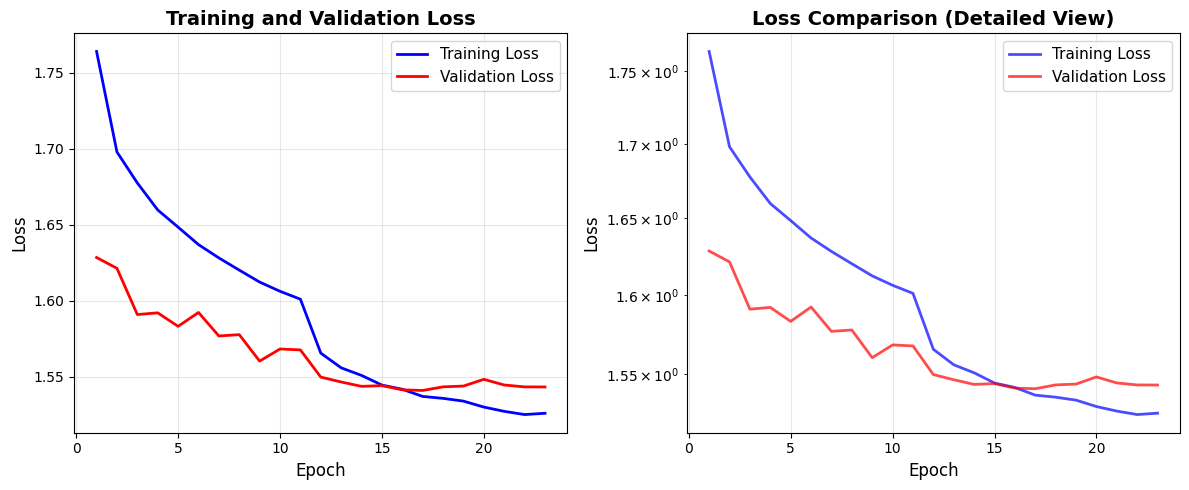


===== TRAINING SUMMARY =====
Final Training Loss: 1.5259
Final Validation Loss: 1.5432
Best Validation AUC: 0.8536
Total Epochs Trained: 23
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/288 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8120 | F1: 0.4041
[Test] Cardiomegaly AUC: 0.9391 | F1: 0.4854
[Test] Consolidation AUC: 0.7742 | F1: 0.2204
[Test] Edema AUC: 0.8908 | F1: 0.2788
[Test] Effusion AUC: 0.8987 | F1: 0.6042
[Test] Emphysema AUC: 0.9668 | F1: 0.5390
[Test] Fibrosis AUC: 0.8416 | F1: 0.1679
[Test] Hernia AUC: 0.9896 | F1: 0.7059
[Test] Infiltration AUC: 0.6999 | F1: 0.4088
[Test] Mass AUC: 0.9015 | F1: 0.4748
[Test] Nodule AUC: 0.7666 | F1: 0.3574
[Test] Pleural_Thickening AUC: 0.8012 | F1: 0.2276
[Test] Pneumonia AUC: 0.6845 | F1: 0.0460
[Test] Pneumothorax AUC: 0.8881 | F1: 0.3413
[Test] Avg AUC: 0.8468, Avg F1: 0.3758


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 1.6276
Avg AUROC : 0.8468
Avg F1    : 0.3758

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8120     0.4041     0.2331    
Cardiomegaly         0.9391     0.4854     0.2421    
Consolidation        0.7742     0.2204     0.1465    
Edema                0.8908     0.2788     0.2150    
Effusion             0.8987     0.6042     0.3256    
Emphysema            0.9668     0.5390     0.1862    
Fibrosis             0.8416     0.1679     0.1683    
Hernia               0.9896     0.7059     0.4064    
Infiltration         0.6999     0.4088     0.2910    
Mass                 0.9015     0.4748     0.2774    
Nodule               0.7666     0.3574     0.2292    
Pleural_Thickening   0.8012     0.2276     0.1149    
Pneumonia            0.6845     0.0460     0.1279    
Pneumothorax         0.8881     0.3413     0.1396    

Average Optimal Thresho

Generating predictions:   0%|          | 0/288 [00:00<?, ?it/s]

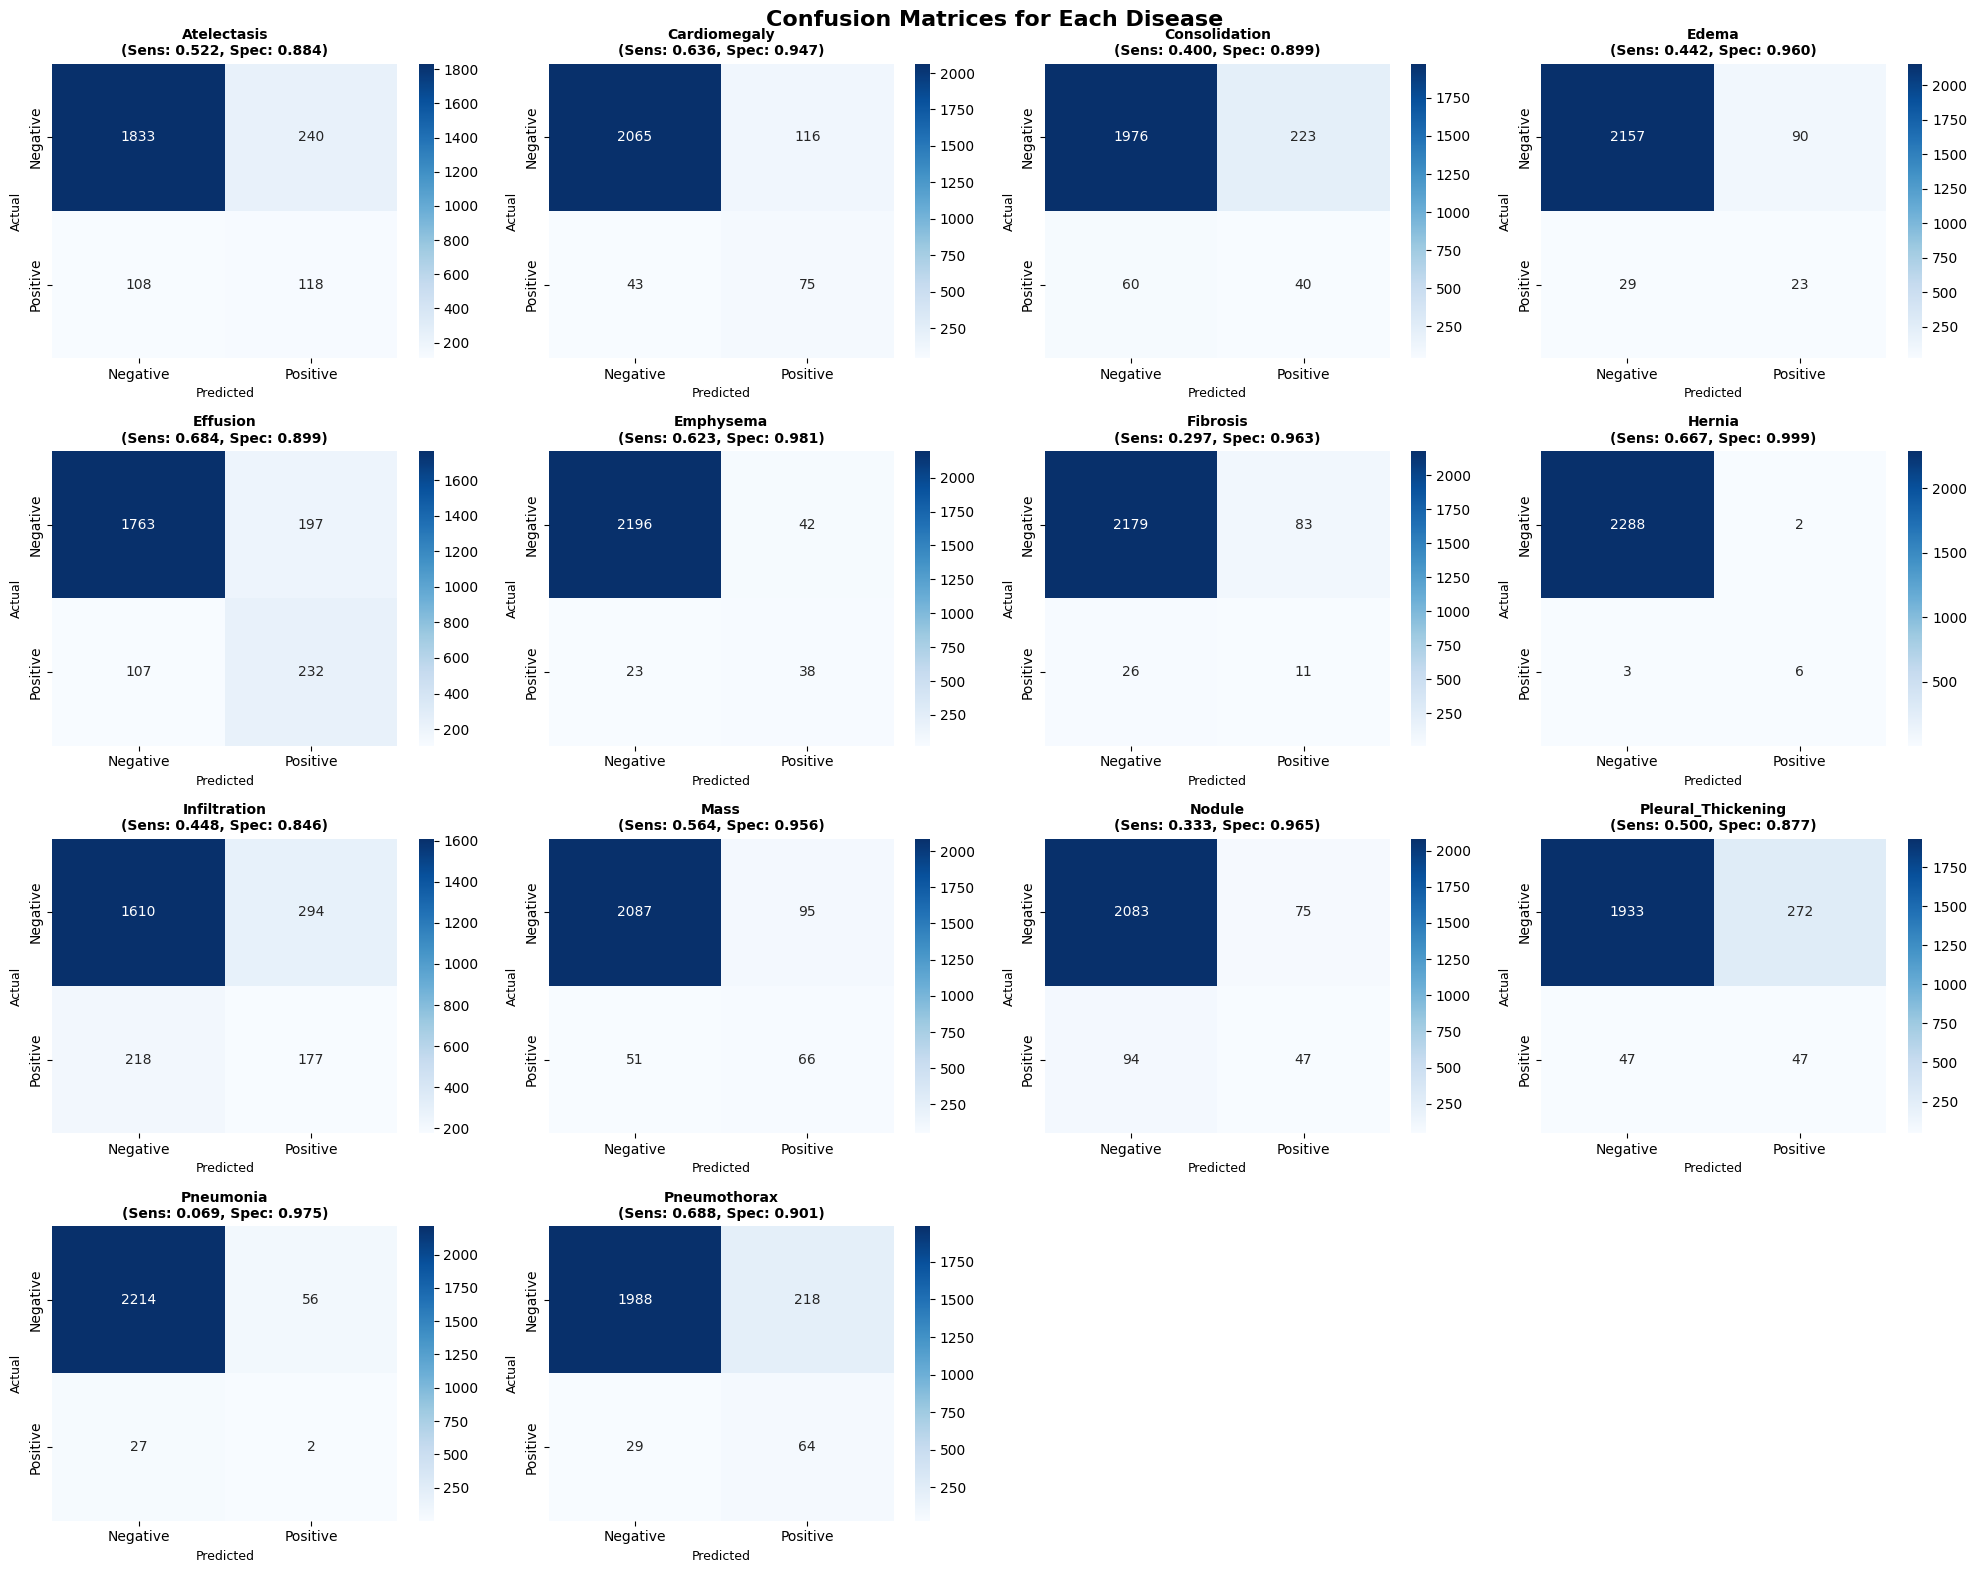

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          118    1833   240    108    0.522    0.884    0.330    0.944   
Cardiomegaly         75     2065   116    43     0.636    0.947    0.393    0.980   
Consolidation        40     1976   223    60     0.400    0.899    0.152    0.971   
Edema                23     2157   90     29     0.442    0.960    0.204    0.987   
Effusion             232    1763   197    107    0.684    0.899    0.541    0.943   
Emphysema            38     2196   42     23     0.623    0.981    0.475    0.990   
Fibrosis             11     2179   83     26     0.297    0.963    0.117    0.988   
Hernia               6      2288   2      3      0.667    0.999    0.750    0.999   
Infiltration         177    1610   294    218    0.448    0.846    0.376    0.881   
Ma